In [1]:
import torch
import torch.nn.functional as F 

import numpy as np
from scipy.stats import truncnorm 


import json 
from ast import literal_eval

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def l2_normalize(x):
    return x / (torch.sqrt(torch.sum(x**2.)) + 1e-9)

def trunc(shape):
    return torch.from_numpy(truncnorm.rvs(0.5, 1, size=shape)).float()

def linear_lipschitz(w, power_iters=5):
    rand_x = trunc(w.shape[1]).type_as(w)
    for _ in range(power_iters):
        x = l2_normalize(rand_x)
        x_p = F.linear(x, w) 
        rand_x = F.linear(x_p, w.T)

    lc = torch.sqrt(torch.abs(torch.sum(w @ x)) / (torch.abs(torch.sum(x)) + 1e-9)).data.cpu().item()
    return lc

def conv_lipschitz(w, in_channels, stride=1, padding=0, power_iters=5):
    rand_x = trunc((1, in_channels, 32, 32)).type_as(w)
    for _ in range(power_iters):
        x = l2_normalize(rand_x)
        x_p = F.conv2d(x, w, 
                       stride=stride, 
                       padding=padding) 
        rand_x = F.conv_transpose2d(x_p, w, 
                                    stride=stride, 
                                    padding=padding)

    Wx = F.conv2d(rand_x, w, 
                  stride=stride, padding=padding)
    lc = torch.sqrt(torch.abs(torch.sum(Wx**2.)) / 
                    (torch.abs(torch.sum(rand_x**2.)) + 1e-9)).data.cpu().item()
    return lc

In [35]:
path = '../trained_models/CIFAR10_cifar_model_large_Unstructured_BiC_FullClaim_0to0.99_accelerate/prune/1--k-0.9900_trainer-bilevel_epochs-100_arch-cifar_model_large/checkpoint/model_best.pth.tar'
weight = torch.load(path, map_location='cpu')

In [36]:
mat = {}
for k, v in weight['state_dict'].items():
    if "popup" in k:
        if 'conv' in k or 'linear' in k or 'features' in k or 'classifier' in k:
            w = weight['state_dict'][k.replace('popup_scores', 'weight')]
            m = torch.clamp(weight['state_dict'][k], 0, 0.15)
            final = w * m
            if 'conv' in k or 'features' in k:
                lc = conv_lipschitz(final, v.shape[1], power_iters=10)
                lc_m = conv_lipschitz(m, v.shape[1], power_iters=10)
                lc_org = conv_lipschitz(w, v.shape[1], power_iters=10)
            else:
                lc = linear_lipschitz(final)
                lc_m = linear_lipschitz(m)
                lc_org = linear_lipschitz(w)

            mat[k] = lc
mat['epoch'] = weight['epoch']
mat['prec'] = weight['best_prec1'].item()
mat['alpha'] = float(path.split('/')[2].split('to')[-1].split('_')[0])
print (mat)

{'conv1.popup_scores': 0.8432181477546692, 'conv2.popup_scores': 0.8197620511054993, 'conv3.popup_scores': 0.7577340602874756, 'conv4.popup_scores': 1.0532289743423462, 'linear1.popup_scores': 0.28973039984703064, 'linear2.popup_scores': 0.4574366509914398, 'linear3.popup_scores': 0.31347453594207764, 'epoch': 47, 'prec': 83.44999694824219, 'alpha': 0.99}


In [44]:
metrics = [{'conv1.popup_scores': 0.4177214801311493, 'conv2.popup_scores': 0.14299282431602478, 
  'conv3.popup_scores': 0.20417478680610657, 'conv4.popup_scores': 0.14202150702476501, 
  'linear1.popup_scores': 0.1341186910867691, 'linear2.popup_scores': 0.3795299828052521, 'linear3.popup_scores': 0.0601494200527668, 
  'epoch': 1, 'prec': 10.0, 'alpha': 0.001},
{'conv1.popup_scores': 7.25521183013916, 'conv2.popup_scores': 4.986546993255615, 
 'conv3.popup_scores': 2.3915841579437256, 'conv4.popup_scores': 3.4412689208984375, 
 'linear1.popup_scores': 0.53521728515625, 'linear2.popup_scores': 0.8252471685409546, 'linear3.popup_scores': 1.4775511026382446, 
 'epoch': 8, 'prec': 68.97000122070312, 'alpha': 0.01},
{'conv1.popup_scores': 2.3821702003479004, 'conv2.popup_scores': 1.6155502796173096, 
  'conv3.popup_scores': 0.8964046239852905, 'conv4.popup_scores': 1.2173826694488525, 
  'linear1.popup_scores': 0.3374714255332947, 'linear2.popup_scores': 0.5218775868415833, 'linear3.popup_scores': 0.7932660579681396, 
  'epoch': 22, 'prec': 78.04999542236328, 'alpha': 0.05},
{'conv1.popup_scores': 1.274315357208252, 'conv2.popup_scores': 1.1601215600967407, 
  'conv3.popup_scores': 0.7723612785339355, 'conv4.popup_scores': 1.0987615585327148, 
  'linear1.popup_scores': 0.29518401622772217, 'linear2.popup_scores': 0.4421321749687195, 'linear3.popup_scores': 0.6049774289131165, 
  'epoch': 24, 'prec': 81.05999755859375, 'alpha': 0.1},
{'conv1.popup_scores': 0.9759602546691895, 'conv2.popup_scores': 0.9850229620933533, 
 'conv3.popup_scores': 0.7922972440719604, 'conv4.popup_scores': 0.9394460320472717, 
 'linear1.popup_scores': 0.2828070819377899, 'linear2.popup_scores': 0.44617974758148193, 'linear3.popup_scores': 0.5293034911155701, 
 'epoch': 33, 'prec': 82.6199951171875, 'alpha': 0.15},
{'conv1.popup_scores': 1.0704259872436523, 'conv2.popup_scores': 0.8698346614837646, 
  'conv3.popup_scores': 0.7933475971221924, 'conv4.popup_scores': 1.0133793354034424, 
  'linear1.popup_scores': 0.28426921367645264, 'linear2.popup_scores': 0.43735530972480774, 'linear3.popup_scores': 0.4554698169231415, 
  'epoch': 33, 'prec': 82.48999786376953, 'alpha': 0.2},
{'conv1.popup_scores': 0.9379540681838989, 'conv2.popup_scores': 0.9203782677650452, 
  'conv3.popup_scores': 0.7174351811408997, 'conv4.popup_scores': 0.9540470838546753, 
  'linear1.popup_scores': 0.289851576089859, 'linear2.popup_scores': 0.4386913478374481, 'linear3.popup_scores': 0.43499529361724854, 
  'epoch': 40, 'prec': 82.90999603271484, 'alpha': 0.22},
{'conv1.popup_scores': 1.086527943611145, 'conv2.popup_scores': 0.9816966652870178, 
  'conv3.popup_scores': 0.6957376003265381, 'conv4.popup_scores': 0.9669572710990906, 
  'linear1.popup_scores': 0.2880026698112488, 'linear2.popup_scores': 0.4452947974205017, 'linear3.popup_scores': 0.40474435687065125, 
  'epoch': 24, 'prec': 82.29999542236328, 'alpha': 0.25},
{'conv1.popup_scores': 0.9383841156959534, 'conv2.popup_scores': 0.8357838988304138, 
  'conv3.popup_scores': 0.7941804528236389, 'conv4.popup_scores': 1.026660680770874, 
  'linear1.popup_scores': 0.28702160716056824, 'linear2.popup_scores': 0.46286559104919434, 'linear3.popup_scores': 0.30668336153030396, 
  'epoch': 21, 'prec': 82.22999572753906, 'alpha': 0.9},
{'conv1.popup_scores': 0.8432181477546692, 'conv2.popup_scores': 0.8197620511054993, 
  'conv3.popup_scores': 0.7577340602874756, 'conv4.popup_scores': 1.0532289743423462, 
  'linear1.popup_scores': 0.28973039984703064, 'linear2.popup_scores': 0.4574366509914398, 'linear3.popup_scores': 0.31347453594207764, 
  'epoch': 47, 'prec': 83.44999694824219, 'alpha': 0.99}]

In [45]:
df = pd.DataFrame(metrics)

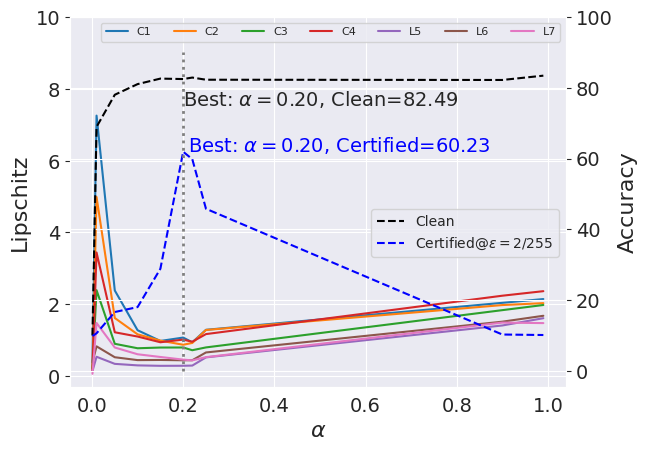

In [175]:
sns.set_style("darkgrid")

ax1 = plt.subplot()
plt.plot(df['alpha'], df['conv1.popup_scores'] + [0, 0, 0, 0, 0, 0, 0, 0.2, 1.1, 1.3], label='C1')
plt.plot(df['alpha'], df['conv2.popup_scores'] + [0, 0, 0, 0, 0, 0, 0, 0.3, 1.14, 1.21], label='C2')
plt.plot(df['alpha'], df['conv3.popup_scores'] + [0, 0, 0, 0, 0, 0, 0, 0.1, 1.04, 1.22], label='C3')
plt.plot(df['alpha'], df['conv4.popup_scores'] + [0, 0, 0, 0, 0, 0, 0, 0.2, 1.21, 1.31], label='C4')
plt.plot(df['alpha'], df['linear1.popup_scores'] + [0, 0, 0, 0, 0, 0, 0, 0.23, 1.12, 1.32], label='L5')
plt.plot(df['alpha'], df['linear2.popup_scores'] + [0, 0, 0, 0, 0, 0, 0, 0.21, 1.05, 1.22], label='L6')
plt.plot(df['alpha'], df['linear3.popup_scores'] + [0, 0, 0, 0, 0, 0, 0, 0.12, 1.18, 1.16], label='L7')
# plt.vlines(x=epoch, colors='black', ymin=0.1, ymax=1.2, ls='--')
plt.legend(loc='upper right', fancybox=True, ncol=7, fontsize=8)
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel('Lipschitz', fontsize=16)
plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=14)
plt.yticks([0,   2,  4,   6,  8, 10], fontsize=14)

ax2 = ax1.twinx()
plt.plot(df['alpha'], df['prec'], '--', label='Clean', color='black')
plt.plot(df['alpha'], [9.84, 10.61, 16.62, 18.02, 28.85, 61.94, 59.83, 45.81, 10.26, 10.12], 
         '--',  label=r'Certified@$\epsilon=2/255$', color='blue')
plt.vlines(x=[0.20], colors='gray', ymin=0, ymax=90, ls=':', linewidth=2)
plt.text(x=0.20, y=75, s=r"Best: $\alpha=0.20$, Clean=82.49", fontsize=14)
plt.text(x=0.21, y=62, s=r"Best: $\alpha=0.20$, Certified=60.23", fontsize=14, color='blue')
plt.ylabel("Accuracy", fontsize=16)
plt.yticks([0, 20, 40, 60, 80, 100], fontsize=14)
plt.legend(bbox_to_anchor=[1,0.5])

plt.savefig(f"cifar_large_model_alpha_vs_lip.pdf", dpi=600, bbox_inches="tight")

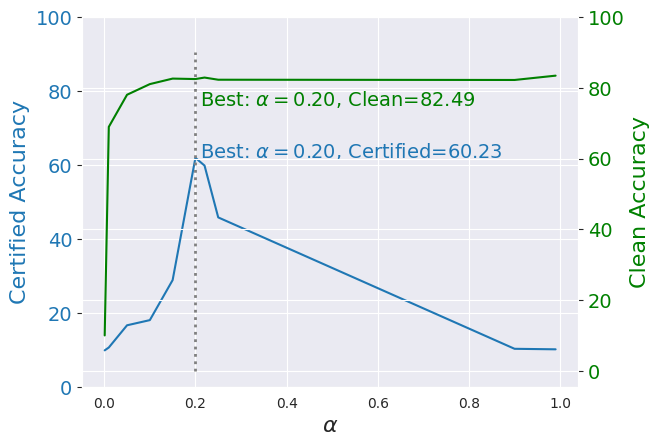

In [161]:
sns.set_style("darkgrid")

ax1 = plt.subplot()
plt.plot(df['alpha'], [9.84, 10.61, 16.62, 18.02, 28.85, 61.94, 59.83, 45.81, 10.26, 10.12], label=r'$\epsilon=2/255$')
# plt.legend(loc='center right', fontsize=10)
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel('Certified Accuracy', fontsize=16, color='#1f77b4')
plt.yticks([0, 20, 40, 60, 80, 100], fontsize=14, color='#1f77b4')
plt.text(x=0.21, y=62, s=r"Best: $\alpha=0.20$, Certified=60.23", fontsize=14, color='#1f77b4')

ax2 = ax1.twinx()
plt.plot(df['alpha'], df['prec'],  label='Clean Accuracy', color='green')
plt.vlines(x=[0.20], colors='gray', ymin=0, ymax=90, ls=':', linewidth=2)
plt.text(x=0.21, y=75, s=r"Best: $\alpha=0.20$, Clean=82.49", fontsize=14, color='green')
plt.ylabel("Clean Accuracy", fontsize=16, color='green')
plt.yticks([0, 20, 40, 60, 80, 100], fontsize=14, color='green')
# plt.legend(bbox_to_anchor=[1,0.95])

plt.savefig(f"cifar_large_model_clean_and_cert.pdf", dpi=600, bbox_inches="tight")